In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mobile-games-ab-testing/cookie_cats.csv


# Data Dictionary

| **Column Name**      | **Description**                                                                                     |
|-----------------------|-----------------------------------------------------------------------------------------------------|
| `userid`             | A unique number that identifies each player.                                                        |
| `version`            | Indicates the group assignment: `gate_30` (control group, gate at level 30) or `gate_40` (test group, gate at level 40). |
| `sum_gamerounds`     | The number of game rounds played by the player during the first week after installation.             |
| `retention_1`        | Indicates whether the player returned and played 1 day after installation (`1` for yes, `0` for no). |
| `retention_7`        | Indicates whether the player returned and played 7 days after installation (`1` for yes, `0` for no).|

**Note**:  
Players were randomly assigned to either `gate_30` or `gate_40` upon installing the game.


In [3]:
#Loading the data
data = pd.read_csv('/kaggle/input/mobile-games-ab-testing/cookie_cats.csv')
data

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [5]:
#Checking if there any null values in the dataset
data.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [6]:
data.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [7]:
data.duplicated().sum()

0


### Exploratory Data Analysis & Data Cleaning

In [8]:
#Importing all the packages
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

In [9]:
#Defining custom color palette for all plots
custom_colors = ["#87CEEB", "#FFD580"] 

# Set the color cycle for Matplotlib
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=custom_colors)

# Set the color palette for Seaborn
sns.set_palette(custom_colors)

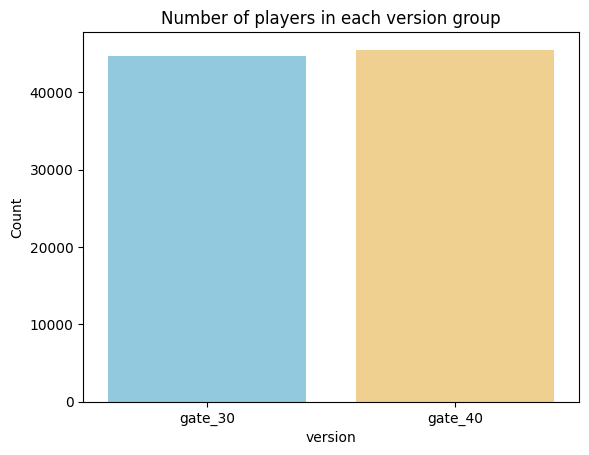

In [10]:
#Count the number of players in each version group
sns.barplot(x = data.groupby(['version'])['userid'].count().index, 
            y = data.groupby(['version'])['userid'].count().values)
plt.title('Number of players in each version group')
plt.ylabel('Count')
plt.show()

If we observe the df.describe() we can see that the max value for the sum_gamerounds variable is 49854. Let's check it using an histogram.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='sum_gamerounds', ylabel='Count'>

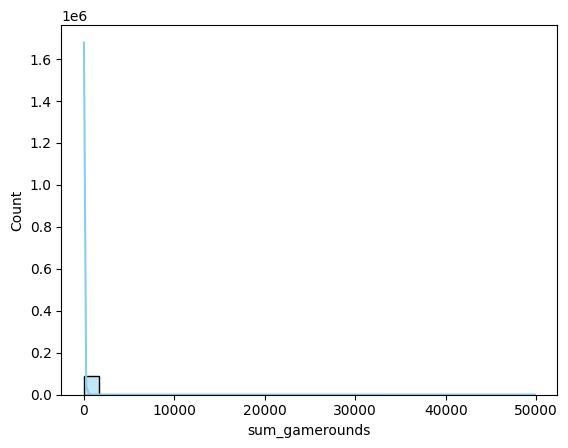

In [11]:
sns.histplot(x = data['sum_gamerounds'], bins = 30, kde = True)

As we can see from the histogram, there is an outlier, as the histogram is highly right skewed, so let's drop it.

In [12]:
# Dropping the outlier in the data
data.drop(data[data['sum_gamerounds'] == 49854].index, axis = 0, inplace=True)

In [13]:
data.reset_index()

,index,userid,version,sum_gamerounds,retention_1,retention_7
0,0,116,gate_30,3,False,False
1,1,337,gate_30,38,True,False
2,2,377,gate_40,165,True,False
3,3,483,gate_40,1,False,False
4,4,488,gate_40,179,True,True
...,...,...,...,...,...,...
90183,90184,9999441,gate_40,97,True,False
90184,90185,9999479,gate_40,30,False,False
90185,90186,9999710,gate_30,28,True,False
90186,90187,9999768,gate_40,51,True,False


### Analyzing the data

### 1- day retention

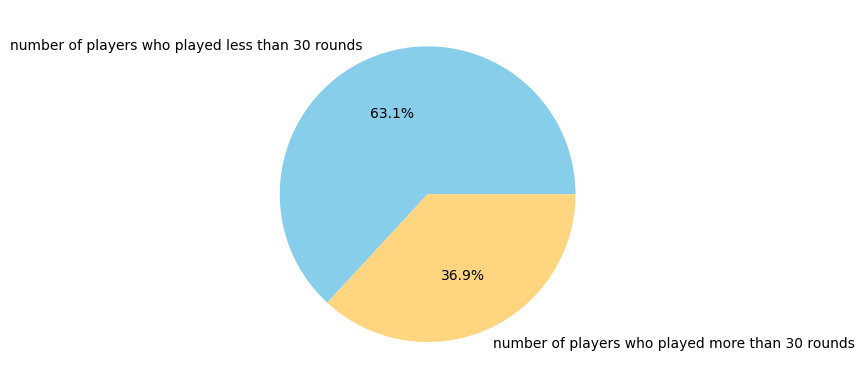

In [14]:
#percentage of people who played less than 30 rounds and more than 30 rounds in total
plt.pie([len(data[data['sum_gamerounds'] < 30]), len(data[data['sum_gamerounds'] >= 30])], 
        labels = ['number of players who played less than 30 rounds', 'number of players who played more than 30 rounds'],
        autopct = '%1.1f%%')
plt.show()

Analyzing the 1-day retention and its impact on each version

In [15]:
#What is the 1-day retention rate for players across both versions combined?
data['retention_1'].value_counts()[1]/len(data) *100

/tmp/ipykernel_30/33526349.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['retention_1'].value_counts()[1]/len(data) *100


44.521444094558035

In [16]:
# 1- day retention for each versions
retention_1_version = data[data['retention_1'] == True]['version'].value_counts()
retention_1_version

version
gate_40    20119
gate_30    20034
Name: count, dtype: int64

/tmp/ipykernel_30/1509149411.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.pie([retention_1_version[0], retention_1_version[1]],


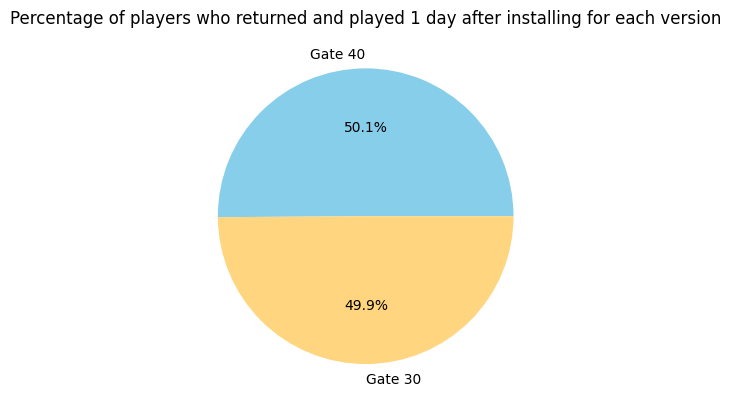

In [17]:
plt.pie([retention_1_version[0], retention_1_version[1]], 
        labels = ['Gate 40', 'Gate 30'],
        autopct='%1.1f%%')
plt.title('Percentage of players who returned and played 1 day after installing for each version')
plt.show()

### 7 - day retention

In [18]:
#What is the 7-day retention rate for players across both versions combined?
data['retention_7'].value_counts()[1]/len(data) *100

/tmp/ipykernel_30/616527438.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['retention_7'].value_counts()[1]/len(data) *100


18.60557945624695

Analyzing the 7-day retention and its impact on each version

In [19]:
#7- days retention for each versions
retention_7_version = data[data['retention_7'] == True]['version'].value_counts()
retention_7_version

version
gate_30    8501
gate_40    8279
Name: count, dtype: int64

/tmp/ipykernel_30/4177656432.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.pie([retention_7_version[0], retention_7_version[1]],


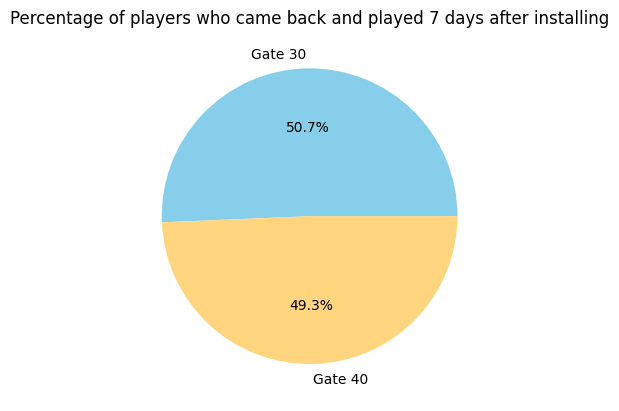

In [20]:
plt.pie([retention_7_version[0], retention_7_version[1]], 
        labels = ['Gate 30', 'Gate 40'],
        autopct='%1.1f%%')
plt.title('Percentage of players who came back and played 7 days after installing')
plt.show()

As from the pie charts, we can observe that the version didn't have an effect on the retention of players, whether its 1 day or 7 days after installing. So, to see if this statement is staisitcally significant, let's use hypothesis testing. Since one of the variable is categorical variable and the other is numerical variable, we can use chi-square testing

### Hypothesis Testing

Ho: The version has no effect on retention of players who played 1 day/7 days after the change.<br>
H1: The version has an effect on retention of players who played 1 day/7 days after the change.

Using chi-sqaure test for hypothesis testing

In [21]:
#Function for chi-square testing
def chi_sq(var1, var2, alpha = 0.05):
    table = pd.crosstab(data[var1],data[var2])
    print("Contigency table:", table)
    chi2, p, dof, expected = chi2_contingency(table)

    print("Chi-Square value:", chi2)
    print("p-value:", p)

    if p < alpha:
        print(f"Since p value is less than {alpha}, we reject the null hypothesis.")
    else:
        print(f"Since p value is greater than {alpha}, we fail to reject the null hypothesis.")

In [22]:
chi_sq('version', 'retention_1')

Contigency table: retention_1  False  True 
version                  
gate_30      24665  20034
gate_40      25370  20119
Chi-Square value: 3.169835543170799
p-value: 0.07500999897705693
Since p value is greater than 0.05, we fail to reject the null hypothesis.


In [23]:
chi_sq('version', 'retention_7')

Contigency table: retention_7  False  True 
version                  
gate_30      36198   8501
gate_40      37210   8279
Chi-Square value: 9.91527552890567
p-value: 0.0016391259678654425
Since p value is less than 0.05, we reject the null hypothesis.


We want to determine whether the change in version (`gate_30` vs. `gate_40`) has a significant impact on the total number of game rounds played. To test this, we will perform a **t-test** to compare the means of `sum_gamerounds` between the two groups. <br>
Some of the assumptions for the t-test are:
1. Data should be normally distributed within each group
2. The variances of the two groups should be approximately equal.

Checking the normality assumption:

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='sum_gamerounds', ylabel='Count'>

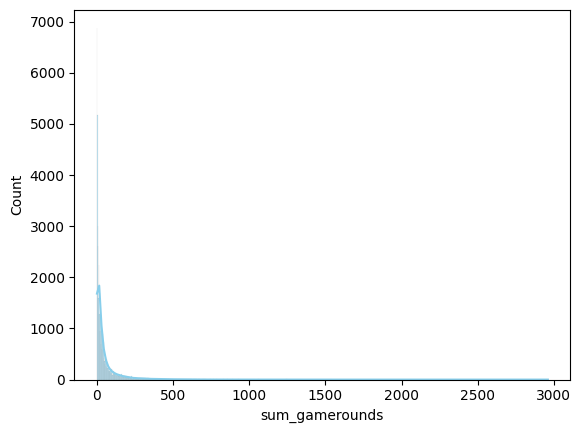

In [24]:
sns.histplot(data[data['version'] == 'gate_30']['sum_gamerounds'], kde=True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='sum_gamerounds', ylabel='Count'>

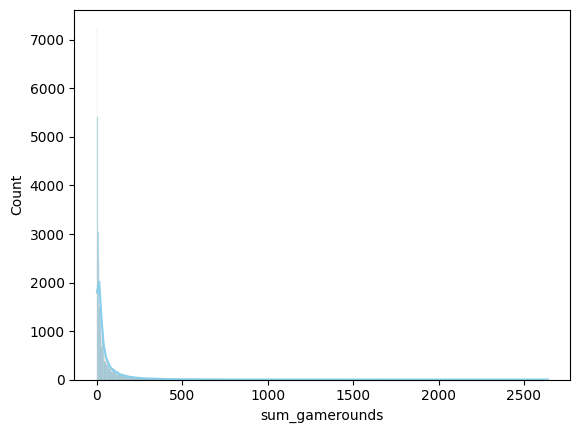

In [25]:
sns.histplot(data[data['version'] == 'gate_40']['sum_gamerounds'], kde=True)

In [35]:
#Defining the 2 groups
group_a = data[data['version'] == 'gate_30']['sum_gamerounds']
group_b = data[data['version'] == 'gate_40']['sum_gamerounds']

In [26]:
for group in data['version'].unique():
    group_data = data[data['version'] == group]['sum_gamerounds']
    stat, p = shapiro(group_data)
    print(f"Group {group}: W-statistic={stat}, P-value={p}")

    if p > 0.05:
        print(f"Group {group} is approximately normal.")
    else:
        print(f"Group {group} is not normal.")


Group gate_30: W-statistic=0.48864023065330064, P-value=2.3625307025017602e-139
Group gate_30 is not normal.
Group gate_40: W-statistic=0.482561004889815, P-value=3.3446548187520663e-140
Group gate_40 is not normal.


/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 44699.
  res = hypotest_fun_out(*samples, **kwds)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 45489.
  res = hypotest_fun_out(*samples, **kwds)


Both of the groups are not normal, since the sample size is greater than 30, we can still use ttest according to the CLT.

Checking the equality of variances assumption using levene test:

In [33]:
from scipy.stats import levene
stat, p = levene(group_a, group_b)
print(f"P-Value: {p}")
if p > 0.05:
    print("Variances are equal.")
else:
    print("Variances are not equal.")


P-Value: 0.7840494387892463
Variances are equal.


In [34]:
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(group_a, group_b, equal_var = True)

print(f"T-Statistic: {t_stat}")
print(f"p-value: {p_value}")

T-Statistic: 0.0633675766982082
p-value: 0.9494739458256001
